# Basic Exploratory Data Analysis

A starter notebook to begin characterizing the segmented hemorrhages in the [public dataset](https://www.mdpi.com/2306-5729/5/1/14) we are analyzing as a part of **Aim 1.1: Characterizing Real ICH**

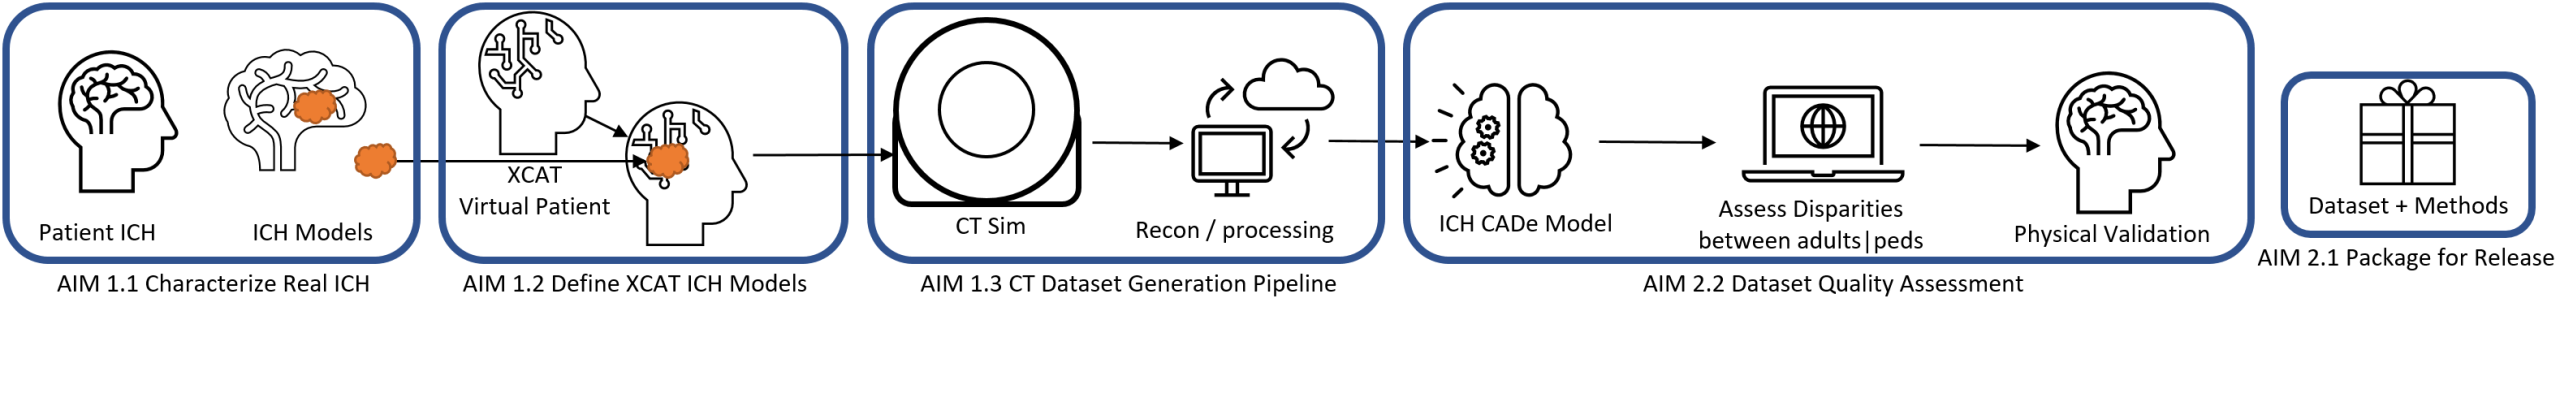

## Introduction 

Previously, [patient_demographics.ipynb](patient_demographics.ipynb) began characterizing the [patient metadata](/gpfs_projects/common_data/CT_intracranial_hemorrhage/patient_demographics.csv) of this dataset. *The same could be done to characterize the lesions themselves using [hemorrhage_diagnosis.csv](/gpfs_projects/common_data/CT_intracranial_hemorrhage/hemorrhage_diagnosis.csv).*

### Aim

The aim of this notebook is to now characterize the images and ground truth segmentation labels. Some basic characterizations of CT hemorrhage include (but are not limited to) - links to papers or implementations would also be helpful -:

**morphology**
- hemorrhage volume
- [circularity](https://scikit-image.org/docs/stable/auto_examples/segmentation/plot_regionprops.html) - scikit-image region props has other simple shape descriptors
- location in the brain (hemisphere, proximity to skull or other structures, etc..)

**contrast**
- [pixel intensity histograms](https://datacarpentry.org/image-processing/05-creating-histograms.html) in and around the segmentations

**texture**
- pixel heteorogeneity within and around the segmentations

### Resources

- [CaPTK](https://www.med.upenn.edu/cbica/captk/): developed for characterizing cancer imaging phenotypes, but many of the quantitative radiomic tools are likely also applicable here too
- [pyradiomics](https://pyradiomics.readthedocs.io/en/latest/): for radiomic feature extraction
- [Mahotas](https://mahotas.readthedocs.io/en/latest/) Computer vision in python, has some useful features for texture characterization - like [Haralick features](https://mahotas.readthedocs.io/en/latest/features.html#haralick-features)
- [OpenCV](https://docs.opencv.org/4.x/d9/d97/tutorial_table_of_content_features2d.html): a collection of tutorials using OpenCV for feature extraction

In [1]:
!ls /gpfs_projects/common_data/CT_intracranial_hemorrhage

ct_ich.yml		  LICENSE.txt		    Patients_CT  SHA256SUMS.txt
hemorrhage_diagnosis.csv  patient_demographics.csv  README.txt	 split_data.py


In [2]:
!cat /gpfs_projects/common_data/CT_intracranial_hemorrhage/README.txt

By Murtadha Hssayeni, mhssayeni2017@fau.edu 8/13/2018

Dataset name: Computed Tomography Images for Intracranial Hemorrhage Detection and Segmentation
Authors: Murtadha D. Hssayeni, M.S., Muayad S. Croock, Ph.D., Aymen Al-Ani, Ph.D., Hassan Falah Al-khafaji, M.D. and Zakaria A. Yahya, M.D.


A retrospective study was designed to collect head CT scans of subjects with TBI and it was approved by the research and ethics board in the Iraqi ministry of health-Babil Office. CT scans were collected between February and August 2018 from Al Hilla Teaching Hospital-Iraq. Patients information were anonymized. A dataset of 82 CT scans was collected that included 36 scans for patients diagnosed with intracranial hemorrhage with the following types (Intraventricular, Intraparenchymal, Subarachnoid, Epidural and Subdural). Each CT scan for each patient includes about 30 slices with 5 mm slice-thickness. The mean and std of patients' age are 27.8 and 19.5, respectively. 46 of the patients are males an

## Looking at the images and filtering by the metadata

This brief section aims to familiarize us with the dataset by making it easier to look at the images in the different displays, overlay the hemorrhage segmentations if they exist, and compare against the provided patient-level and lesion-level metadata

In [3]:
!pip install -q -r requirements.txt

In [4]:
import pandas as pd
from pathlib import Path

base_dir = Path('/gpfs_projects/common_data/CT_intracranial_hemorrhage')
patients_df = pd.read_csv(base_dir / 'patient_demographics.csv')
patients_df.head()

,Patient Number,Age\n(years),Gender,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,Fracture (Yes/No),Condition on file,Note
0,49,35.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN
1,50,0.583333,Female,NaN,1.0,NaN,NaN,NaN,1.0,Subdural HGE,NaN
2,51,5.000000,Male,NaN,1.0,NaN,NaN,1.0,1.0,Extadural HGE,NaN
3,52,8.000000,Male,NaN,NaN,NaN,1.0,NaN,1.0,Extadural HGE,NaN
4,53,44.000000,Male,NaN,1.0,NaN,1.0,NaN,1.0,Intracranial HGE+ Extradural HGE,NaN


We previously looked at this dataframe in more detail here: [patient_demographics.ipynb](patient_demographics.ipynb)

In [5]:
hemorrhages_df = pd.read_csv(base_dir / 'hemorrhage_diagnosis.csv')
hemorrhages_df

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No
0,49,1,0,0,0,0,0,1,0
1,49,2,0,0,0,0,0,1,0
2,49,3,0,0,0,0,0,1,0
3,49,4,0,0,0,0,0,1,0
4,49,5,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...
2496,130,27,0,0,0,0,0,1,0
2497,130,28,0,0,0,0,0,1,0
2498,130,29,0,0,0,0,0,1,0
2499,130,30,0,0,0,0,0,1,0


Let's add columns for file locations to make accessing images easier like a database..

In [6]:
for display in ['brain', 'bone']:
    hemorrhages_df[f'{display} filename'] = base_dir / 'Patients_CT' / (hemorrhages_df['PatientNumber'].apply(lambda o: str(o).zfill(3)) + '/' + display + '/' + hemorrhages_df['SliceNumber'].astype(str) + '.jpg')
hemorrhages_df.head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,brain filename,bone filename
0,49,1,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
1,49,2,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
2,49,3,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
3,49,4,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
4,49,5,0,0,0,0,0,1,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...


In [7]:
hemorrhages_df['brain filename'].head()

0    /gpfs_projects/common_data/CT_intracranial_hem...
1    /gpfs_projects/common_data/CT_intracranial_hem...
2    /gpfs_projects/common_data/CT_intracranial_hem...
3    /gpfs_projects/common_data/CT_intracranial_hem...
4    /gpfs_projects/common_data/CT_intracranial_hem...
Name: brain filename, dtype: object

Now we can easily filter the dataframe and look at the images we want, say those with hemorrhage for example. Now, I interpret `No_Hemorrhage` to mean *no* hemorrhage, as in columns: `Intraventricular`, `Intraparenchymal`,	`Subarachnoid`, `Epidural`,	`Subdural` are all 0, so we can use this to filter to slices that *do* have hemorrhage by filter by the rows where this condition is False

In [8]:
hemorrhages_df[hemorrhages_df['No_Hemorrhage'] == False].head()

,PatientNumber,SliceNumber,Intraventricular,Intraparenchymal,Subarachnoid,Epidural,Subdural,No_Hemorrhage,Fracture_Yes_No,brain filename,bone filename
13,49,14,0,0,0,1,0,0,1,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
14,49,15,0,0,0,1,0,0,1,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
15,49,16,0,0,0,1,0,0,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
16,49,17,0,0,0,1,0,0,0,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...
19,49,20,0,0,0,1,0,0,1,/gpfs_projects/common_data/CT_intracranial_hem...,/gpfs_projects/common_data/CT_intracranial_hem...


Let's also define a function to get the segmentation mask if it exists.

In [9]:
!ls /gpfs_projects/common_data/CT_intracranial_hemorrhage/Patients_CT/049/brain/

10.jpg		15.jpg		1.jpg		23_HGE_Seg.jpg	28.jpg	3.jpg
11.jpg		16_HGE_Seg.jpg	20_HGE_Seg.jpg	23.jpg		29.jpg	4.jpg
12.jpg		16.jpg		20.jpg		24.jpg		2.jpg	5.jpg
13.jpg		17_HGE_Seg.jpg	21_HGE_Seg.jpg	25.jpg		30.jpg	6.jpg
14_HGE_Seg.jpg	17.jpg		21.jpg		26.jpg		31.jpg	7.jpg
14.jpg		18.jpg		22_HGE_Seg.jpg	27_HGE_Seg.jpg	32.jpg	8.jpg
15_HGE_Seg.jpg	19.jpg		22.jpg		27.jpg		33.jpg	9.jpg


In [10]:
def get_hemorrhage_mask(filename):
    filename = Path(filename)
    mask_filename = filename.parent / (filename.stem + '_HGE_Seg.jpg')
    return mask_filename if mask_filename.exists() else None

In [11]:
get_hemorrhage_mask(hemorrhages_df[hemorrhages_df['No_Hemorrhage'] == False]['brain filename'].iloc[0]), get_hemorrhage_mask(hemorrhages_df[hemorrhages_df['No_Hemorrhage'] == True]['brain filename'].iloc[0])

(PosixPath('/gpfs_projects/common_data/CT_intracranial_hemorrhage/Patients_CT/049/brain/14_HGE_Seg.jpg'),
 None)

Note that if the mask *does not exist* it returns `None`

In [12]:
import matplotlib.pyplot as plt

def display_images(row):
    'requires a `row` from the `hemorrhages_df` dataframe and will print patient and lesion information while showing brain, bone, and lesion images side-by-side'
    print(row)
    print(patients_df[patients_df['Patient Number'] == row.PatientNumber].iloc[0])
    brain_display_filename = row['brain filename']
    bone_display_filename = row['bone filename']
    hemorrhage_mask_filename = get_hemorrhage_mask(brain_display_filename)

    brain_img = plt.imread(brain_display_filename)
    bone_img = plt.imread(bone_display_filename)

    f, axs = plt.subplots(1,3, dpi=300)
    axs[0].axis('off')
    axs[0].imshow(bone_img, cmap='gray')
    axs[0].set_title('bone ww/wl')
    axs[1].axis('off')
    axs[1].imshow(brain_img, cmap='gray')
    axs[1].set_title('brain ww/wl')

    if hemorrhage_mask_filename:
        mask_img = plt.imread(hemorrhage_mask_filename)
        axs[2].axis('off')
        axs[2].imshow(brain_img, cmap='gray')
        axs[2].imshow(mask_img, cmap='Reds', alpha=0.5)
        axs[2].set_title('hemorrhage overlay')

# row = hemorrhages_df[hemorrhages_df['No_Hemorrhage'] == False].iloc[0]
# display_images(row)

In [13]:
from ipywidgets import interact, IntSlider

def display_images_widget(hemorrhage=True, patientnumber=49, image_index=0):
    'note that `image_index` does not necesarrily agree with slice number since `image_index` starts at the bottom of the scan if there is not hemorrhage or at the first segmentation slice if a segmentation is present'
    filtered_df = hemorrhages_df[(hemorrhages_df['No_Hemorrhage'] != hemorrhage) & (hemorrhages_df['PatientNumber']==patientnumber)]
    if image_index > len(filtered_df):
        print(f'image_index: {image_index} exceeds the available slices: {len(filtered_df)}, please select a smaller index to view')
    row = filtered_df.iloc[image_index]
    display_images(row)

max_slice_idx = max([len(hemorrhages_df[(hemorrhages_df.PatientNumber == n)]) for n in hemorrhages_df.PatientNumber.unique()])
    
interact(display_images_widget, hemorrhage=[True, False], patientnumber=patients_df['Patient Number'].unique(), image_index=IntSlider(value=0, min=0, max=max_slice_idx))

interactive(children=(Dropdown(description='hemorrhage', options=(True, False), value=True), Dropdown(descript…

<function __main__.display_images_widget(hemorrhage=True, patientnumber=49, image_index=0)>

## Lesion Morphology
 
Here we can start to aggregate lesion morphology properties like shape, volume - both on the slice-level, and patient-level and plot against patient metadata like age or ICH type to start looking for trends...